In [3]:
# Utilitarios
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime

# Limpeza e tratamento dos dados brutos

Nesta seção, iremos converter os datasets brutos e fragmentados e um único dataset, realizando o merge das informações de ambos os datasets.

In [4]:
files = [
    'BD_Cotton_Safra_2018_19',
    'BD_Cotton_Safra_2019_20',
    'BD_Cotton_Safra_2020_21',
]

In [6]:
dfCompiled = pd.DataFrame()

for filename in files:
    print ('Compilação ->',filename)
    
    df = pd.read_csv(f'./datasets/raw/{filename}.csv', delimiter = ';', low_memory=False)
    dfCompiled = pd.concat([dfCompiled, df])

dfCompiled.to_csv('./datasets/compiled/BD_Cotton_Safra_2018_21.csv', sep=';', index=False)

Compilação -> BD_Cotton_Safra_2018_19
Compilação -> BD_Cotton_Safra_2019_20
Compilação -> BD_Cotton_Safra_2020_21


Agora, com os dados concatenados, vamos remover as colunas que não iremos utilizar em nosso dataset

In [7]:
def parser(date):
    if '-' in str(date):
        return datetime.strptime(date, '%Y-%m-%d')
    else:
        return datetime.strptime(date, '%d/%m/%Y')

df = pd.read_csv(f'./datasets/compiled/BD_Cotton_Safra_2018_21.csv', sep=';', header=0, low_memory=False, parse_dates=[0, -1], date_parser=parser)
df

,DATA,Nome do Produtor,Propriedade,GLEBA,Lag S frugiperda,DATA PLANTIO
0,2018-10-15,Jacobus Derks,Santa Fé,P3,0,2018-10-03
1,2018-10-15,Jacobus Derks,Santa Fé,P3,0,2018-10-03
2,2018-10-15,Jacobus Derks,Santa Fé,P3,0,2018-10-03
3,2018-10-15,Jacobus Derks,Santa Fé,P3,0,2018-10-03
4,2018-10-15,Jacobus Derks,Santa Fé,P3,0,2018-10-03
...,...,...,...,...,...,...
528487,2021-12-01,José Theodoro Swart,NS do Carmo,C4 cima,0,2021-10-21
528488,2021-12-01,José Theodoro Swart,NS do Carmo,C4 cima,0,2021-10-21
528489,2021-12-01,José Theodoro Swart,NS do Carmo,C4 cima,0,2021-10-21
528490,2021-12-01,José Theodoro Swart,NS do Carmo,C4 cima,0,2021-10-21


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528492 entries, 0 to 528491
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATA              528492 non-null  datetime64[ns]
 1   Nome do Produtor  528492 non-null  object        
 2   Propriedade       528492 non-null  object        
 3   GLEBA             528492 non-null  object        
 4   Lag S frugiperda  528492 non-null  object        
 5   DATA PLANTIO      528492 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(4)
memory usage: 24.2+ MB


In [9]:
df['Lag S frugiperda'].value_counts()

0      521549
P        2478
M        2311
G        1525
ovo       628
p           1
Name: Lag S frugiperda, dtype: int64

<strong>Nesta seção, vamos remodelar a base de dados.</strong><br>

Na base de dados, as ocorrencias são determinadas pelos seguintes valores:<br>
<li>0 -> Nenhuma ocorrencia</li>
<li>ovo -> Ocorrencia de ovo(s) de Spodoptera Frugiperda</li>
<li>P -> Ocorrencia de larvas pequenas de Spodoptera Frugiperda</li>
<li>M -> Ocorrencia de larvas médias de Spodoptera Frugiperda</li>
<li>G -> Ocorrencia de larvas grandes de Spodoptera Frugiperda</li><br>
Nesta seção nós iremos:
<li>Agrupar as coletas da mesma data, criando uma tabela de ocorrencia.<br></li>
<li>Definir a idade que a lavoura tinha, em dias, na data da coleta<br></li>
<li>Definir o estagio que a lavoura estava na data da coleta<br></li>
<li>Criar uma coluna binaria, que para cada registro, terá o valor 0 se não houver ocorrencia e 1 se houver ocorrencias<br></li>

In [10]:
def get_days_difference(initialDay, finalDay):
    diferenca = finalDay - initial_day
    idadeAtual = diferenca.days
    if idadeAtual < 0:
        idadeAtual = idadeAtual * -1
    
    return idadeAtual

def get_estagio(idadeAtual):
    if int(idadeAtual) <= 35:
        return 0
    elif int(idadeAtual) > 35 and int(idadeAtual) <= 70:
        return 1
    elif int(idadeAtual) > 70 and int(idadeAtual) <= 110:
        return 2
    elif int(idadeAtual) > 110:
        return 3

def is_occurrence(row):
    if row['ovo'] != 0 or row['P'] != 0 or row['M'] != 0 or row['G'] != 0:
        val = 1
    else:
        val = 0
    return val
    
def create_dataset_occurrence():
    print ('Process DataFrame Occurrence')
    newDataframeArray = []
    
    for propriedade, gleba in zip(df['Propriedade'], df['GLEBA']):
        if {propriedade : [], 'gleba' : gleba} not in newDataframeArray and str(propriedade) != 'nan':
            newDataframeArray.append({
                propriedade : [],
                'gleba' : gleba,
            })
    for index, new_df in enumerate(newDataframeArray):
        nomePropriedade = list(new_df.keys())[0]
        gleba = new_df['gleba']
        for prop in df.loc[(df['Propriedade'] == nomePropriedade) & (df['GLEBA'] == new_df['gleba'])].values:
            contagem = prop[4]
            datetime = prop[0]
            idade = get_days_difference(prop[5], datetime)
            estagio = get_estagio(idade)

            indexDatetime = [index for index, key_dict in enumerate(new_df[nomePropriedade]) if datetime in key_dict]
            if len(indexDatetime) == 0:
                newDataframeArray[index][nome_propriedade].append({
                    datetime : [{
                        contagem : 1,
                        'estagio' : estagio,
                        'idade' : idade
                    }]
                })
            else:
                indexDatetime = indexDatetime[0]
                indexContagem = [index for index, key_dict in enumerate(new_df[nomePropriedade][indexDatetime][datetime]) if contagem in key_dict]
                if len(indexContagem) == 0:
                    newDataframeArray[index][nomePropriedade][indexDatetime][datetime].append({
                        contagem : 1,
                        'estagio' : estagio,
                        'idade' : idade
                    })
                else:
                    indexContagem = indexContagem[0]
                    newDataframeArray[index][nomePropriedade][indexDatetime][datetime][indexContagem][contagem] = new_df[nomePropriedade][indexDatetime][datetime][indexContagem][contagem] + 1
        
    newDataframe = pd.DataFrame(columns=['data', 'nome_propriedade', 'gleba', 'ovo', 'P', 'M', 'G', 'estagio', 'idade'])

    for lines in newDataframeArray:
        nomePropriedade = list(lines.keys())[0]
        nomeGleba = lines['gleba']
        
        for datas in lines[nomePropriedade]:
            data = list(datas.keys())[0]
            row = {
                'data' : data,
                'nome_propriedade' : nomePropriedade,
                'gleba' : nomeGleba,
                'ovo' : 0,
                'P' : 0,
                'M' : 0,
                'G' : 0,
                'estagio' : 0,
                'idade' : 0,
            }

            for fasePragas in datas[data]:
                fasePraga = list(fasePragas.keys())[0]
                contagemPraga = fasePragas[fasePraga]
                row[fasePraga] = contagemPraga
                estagioPraga = fasePragas['estagio']
                row['estagio'] = estagioPraga
                idadePraga = fasePragas['idade']
                row['idade'] = idadePraga
            
            newRow = pd.DataFrame([row], columns=['data', 'nome_propriedade', 'gleba', 'ovo', 'P', 'M', 'G', 'estagio', 'idade'])
            newDataframe = pd.concat([newRow, newDataframe])

    return newDataframe

In [13]:
dfOccurrence = create_dataset_occurrence()

propriedades = dfOccurrence['nome_propriedade'].unique().tolist()
glebas = dfOccurrence['gleba'].unique().tolist()

dfOccurrence.index = dfOccurrence['data']
dfOccurrence.index = pd.to_datetime(dfOccurrence.index)
dfOccurrence = dfOccurrence.sort_index()

dfOccurrence['ocorrencia'] = dfOccurrence.apply(is_occurrence, axis=1)

dfOccurrence['idade'] = dfOccurrence['idade'].astype('int64')
dfOccurrence['estagio'] = dfOccurrence['estagio'].astype('int64')

dfOccurrence = dfOccurrence.drop(['ovo', 'P', 'M', 'G', 'nome_propriedade', 'gleba', 'data'], axis=1)
dfOccurrence.to_csv('./datasets/compiled/BD_Cotton_Safra_Occurrence.csv',sep=';', index=False)

Process DataFrame Occurrence


0    3413
1    2311
Name: ocorrencia, dtype: int64

In [14]:
print (dfOccurrence)
dfOccurrence['ocorrencia'].value_counts()

            estagio  idade  ocorrencia
data                                  
2018-10-15        0     12           0
2018-10-15        0      8           0
2018-10-15        0      6           0
2018-10-16        0      8           0
2018-10-16        0      5           0
...             ...    ...         ...
2021-12-01        0     35           0
2021-12-01        1     39           1
2021-12-01        1     41           0
2021-12-01        0     15           0
2021-12-01        1     41           0

[5724 rows x 3 columns]


0    3413
1    2311
Name: ocorrencia, dtype: int64

# Obtendo dados Metereologicos e compilando os datasets
Agora, vamos compilar os dados metereológicos diarios que obtemos pelo Inmet com o dataset de ocorrencias

In [23]:
import dateutil.parser

def parser_date(date):
    if '-' in str(date):
        date = str(date).split(' +')[0]
        return dateutil.parser.isoparse(str(date))

dfTemp = pd.read_csv('./datasets/openweathermap/holambra_2.csv', sep="," ,header=0, squeeze=True, parse_dates=[0], date_parser=parser_date)
dfTemp

,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all
0,2017-01-01 00:00:00,23.70,21.96,24.40,1013,86,1.32,334,97
1,2017-01-01 01:00:00,23.92,21.36,24.63,1013,85,1.38,326,100
2,2017-01-01 02:00:00,23.98,21.26,24.64,1014,85,1.52,314,100
3,2017-01-01 03:00:00,22.96,21.34,23.47,1013,94,1.37,299,99
4,2017-01-01 04:00:00,22.10,20.76,22.53,1013,95,1.39,302,95
...,...,...,...,...,...,...,...,...,...
43291,2021-12-09 19:00:00,27.11,27.11,27.11,1011,22,2.56,185,0
43292,2021-12-09 20:00:00,22.72,22.72,22.72,1012,39,3.62,136,0
43293,2021-12-09 21:00:00,22.72,22.72,22.72,1012,39,3.62,136,0
43294,2021-12-09 22:00:00,22.72,22.72,22.72,1012,39,3.62,136,0


In [25]:
dfTemp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43296 entries, 0 to 43295
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dt_iso      43296 non-null  datetime64[ns]
 1   temp        43296 non-null  float64       
 2   temp_min    43296 non-null  float64       
 3   temp_max    43296 non-null  float64       
 4   pressure    43296 non-null  int64         
 5   humidity    43296 non-null  int64         
 6   wind_speed  43296 non-null  float64       
 7   wind_deg    43296 non-null  int64         
 8   clouds_all  43296 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 3.0 MB


In [21]:
def data_divide(data):
    return str(data).split(' ')[0]

dfTemp['data'] = dfTemp['dt_iso'].apply(data_divide)
datas = dfTemp['data'].unique()

In [22]:
newDates = []

for x in datas:
    rows = dfTemp.loc[
        (dfTemp['data'] == x)
    ]
    rows = rows.drop(['dt_iso', 'data'] , axis=1)
    newRow = [x]
    
    for collun in rows.columns:
        mean = round(sum(rows[collun].values) / len(rows), 2)
        newRow.append(mean)
            
    newDates.append(
        newRow
    )
    
dfTempNew = pd.DataFrame(newDates, columns=['data', 'temp','temp_min','temp_max','pressure','humidity','wind_speed','wind_deg','clouds_all'])
dfTempNew.index = pd.to_datetime(dfTempNew['data'])
dfTempNew = dfTempNew.drop(['data'], axis=1)
dfTempNew

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all
data,,,,,,,,
2017-01-01,25.10,23.00,25.80,1012.79,79.04,2.76,297.83,85.58
2017-01-02,25.22,23.34,26.12,1011.50,79.25,2.21,260.04,82.71
2017-01-03,24.76,23.70,25.65,1011.83,80.58,2.82,121.50,76.08
2017-01-04,24.83,23.32,25.46,1012.08,78.46,2.26,191.21,60.04
2017-01-05,24.36,22.39,25.08,1013.33,82.83,2.60,283.17,82.29
...,...,...,...,...,...,...,...,...
2021-12-05,20.78,20.78,20.78,1015.38,68.88,2.83,163.46,27.75
2021-12-06,21.62,21.62,21.62,1013.42,72.83,2.39,130.54,32.88
2021-12-07,18.25,18.25,18.25,1014.96,76.08,5.58,127.42,36.75


In [26]:
dfOccurrenceTemp = pd.merge(dfTempNew, dfOccurrence, left_index=True, right_index=True)
dfOccurrenceTemp.to_csv('./datasets/processed/BD_Cotton_Safra_Occurrence_And_Temp.csv', sep=';')
dfOccurrenceTemp

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,estagio,idade,ocorrencia
data,,,,,,,,,,,
2018-10-15,19.80,19.03,20.55,1012.92,86.25,2.43,141.62,81.67,0,12,0
2018-10-15,19.80,19.03,20.55,1012.92,86.25,2.43,141.62,81.67,0,8,0
2018-10-15,19.80,19.03,20.55,1012.92,86.25,2.43,141.62,81.67,0,6,0
2018-10-16,20.73,19.59,21.47,1012.75,82.50,2.91,112.50,87.83,0,8,0
2018-10-16,20.73,19.59,21.47,1012.75,82.50,2.91,112.50,87.83,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,22.33,22.33,22.33,1008.54,65.79,2.30,185.42,3.88,0,35,0
2021-12-01,22.33,22.33,22.33,1008.54,65.79,2.30,185.42,3.88,1,39,1
2021-12-01,22.33,22.33,22.33,1008.54,65.79,2.30,185.42,3.88,1,41,0


In [27]:
dfOccurrenceTemp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5724 entries, 2018-10-15 to 2021-12-01
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        5724 non-null   float64
 1   temp_min    5724 non-null   float64
 2   temp_max    5724 non-null   float64
 3   pressure    5724 non-null   float64
 4   humidity    5724 non-null   float64
 5   wind_speed  5724 non-null   float64
 6   wind_deg    5724 non-null   float64
 7   clouds_all  5724 non-null   float64
 8   estagio     5724 non-null   int64  
 9   idade       5724 non-null   int64  
 10  ocorrencia  5724 non-null   int64  
dtypes: float64(8), int64(3)
memory usage: 536.6 KB


In [29]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [31]:
phikOverview = dfOccurrenceTemp.phik_matrix()
phikOverview.round(2)

interval columns not set, guessing: ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'estagio', 'idade', 'ocorrencia']


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,estagio,idade,ocorrencia
temp,1.00,0.97,0.97,0.62,0.67,0.58,0.68,0.54,0.45,0.55,0.14
temp_min,0.97,1.00,0.96,0.56,0.70,0.57,0.64,0.59,0.40,0.54,0.15
temp_max,0.97,0.96,1.00,0.59,0.72,0.59,0.65,0.52,0.48,0.56,0.17
pressure,0.62,0.56,0.59,1.00,0.53,0.53,0.65,0.55,0.30,0.44,0.17
humidity,0.67,0.70,0.72,0.53,1.00,0.44,0.56,0.74,0.33,0.46,0.24
wind_speed,0.58,0.57,0.59,0.53,0.44,1.00,0.53,0.37,0.31,0.31,0.06
wind_deg,0.68,0.64,0.65,0.65,0.56,0.53,1.00,0.53,0.26,0.35,0.10
clouds_all,0.54,0.59,0.52,0.55,0.74,0.37,0.53,1.00,0.28,0.41,0.20
estagio,0.45,0.40,0.48,0.30,0.33,0.31,0.26,0.28,1.00,0.98,0.47
idade,0.55,0.54,0.56,0.44,0.46,0.31,0.35,0.41,0.98,1.00,0.56


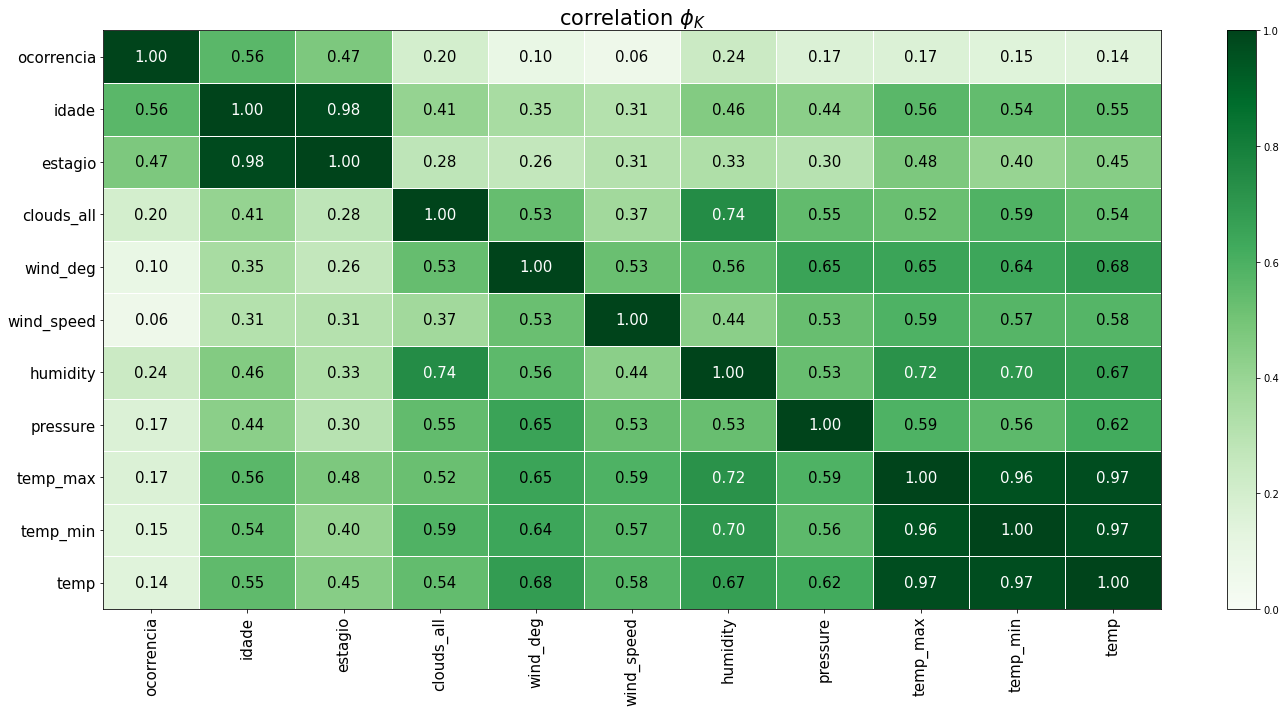

In [32]:
plot_correlation_matrix(phikOverview.values, 
                        x_labels=phikOverview.columns, 
                        y_labels=phikOverview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()